In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/func.ipynb
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/CMIP6_func.ipynb
%matplotlib inline

# Open CMIP6 online catalog & download desired data

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])
waccm.df
cam.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308


In [4]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True}, cdf_kwargs={"chunks": {"time": 40}})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True},cdf_kwargs={"chunks": {"time": 4}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


# Rechunk the dataset to optimize dask

In [5]:
# Each worker should have en even number of workload. 
# For this dataset I have time:1980 divided by 5 gives me an even number of 396.
# I should therefore have 5 workers when using dask.
# This will also wotk if I decide to calculate the yearly mean. 
# I have 165 years. 5 workers will then each have 33 years to work on simultaneously 

# This dataset is already chunked as wished, no need to change

# If change is needed:
#waccm.chunk(time=33).chunks
#waccm.o3[0]

# Krakatoa eruption in 1883

In [7]:
# Select the starting year 5 years prior to the eruption
start_krak = cftime.DatetimeNoLeap(1878,1,15)
end_krak = cftime.DatetimeNoLeap(1888,1,15)

# WACCM
waccm_1877_1887 = waccm.sel(time=slice(start_krak, end_krak))
# CAM
cam_1877_1887 = cam.sel(time=slice(start_krak, end_krak))

# Creates a new variable called totO3 for WACCM and CAM 
waccm_1877_1887_o3 = calculate_total_ozone_p(waccm_1877_1887).totO3
cam_1877_1887_o3 = calculate_total_ozone_p(cam_1877_1887).totO3

Minimum column ozone value: 162.8951380411102
Minimum column ozone value: 176.09250962392275


## Calculate the anomaly

In [11]:
# Yearly
year_waccm_anom_1877_1887_o3 = calc_yearly_anomaly(waccm_1877_1887_o3,1883)
year_cam_anom_1877_1887_o3 = calc_yearly_anomaly(cam_1877_1887_o3,1883)

# Monthly 
mon_waccm_anom_1877_1887_o3 = calc_monthly_anomaly(waccm_1877_1887_o3,1883)
mon_cam_anom_1877_1887_o3 = calc_monthly_anomaly(cam_1877_1887_o3,1883)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [10]:
# Yearly
# WACCM
year_waccm_NH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']>60.)).compute()
year_waccm_SH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']>60.)).compute()
year_cam_SH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']<-60.)).compute()

In [12]:
# Monthly
# WACCM
mon_waccm_NH_anom_krak_o3 = computeWeightedMean(mon_waccm_anom_1877_1887_o3.where(mon_waccm_anom_1877_1887_o3['lat']>60.)).compute()
mon_waccm_SH_anom_krak_o3 = computeWeightedMean(mon_waccm_anom_1877_1887_o3.where(mon_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_krak_o3 = computeWeightedMean(mon_cam_anom_1877_1887_o3.where(mon_cam_anom_1877_1887_o3['lat']>60.)).compute()
mon_cam_SH_anom_krak_o3 = computeWeightedMean(mon_cam_anom_1877_1887_o3.where(mon_cam_anom_1877_1887_o3['lat']<-60.)).compute()

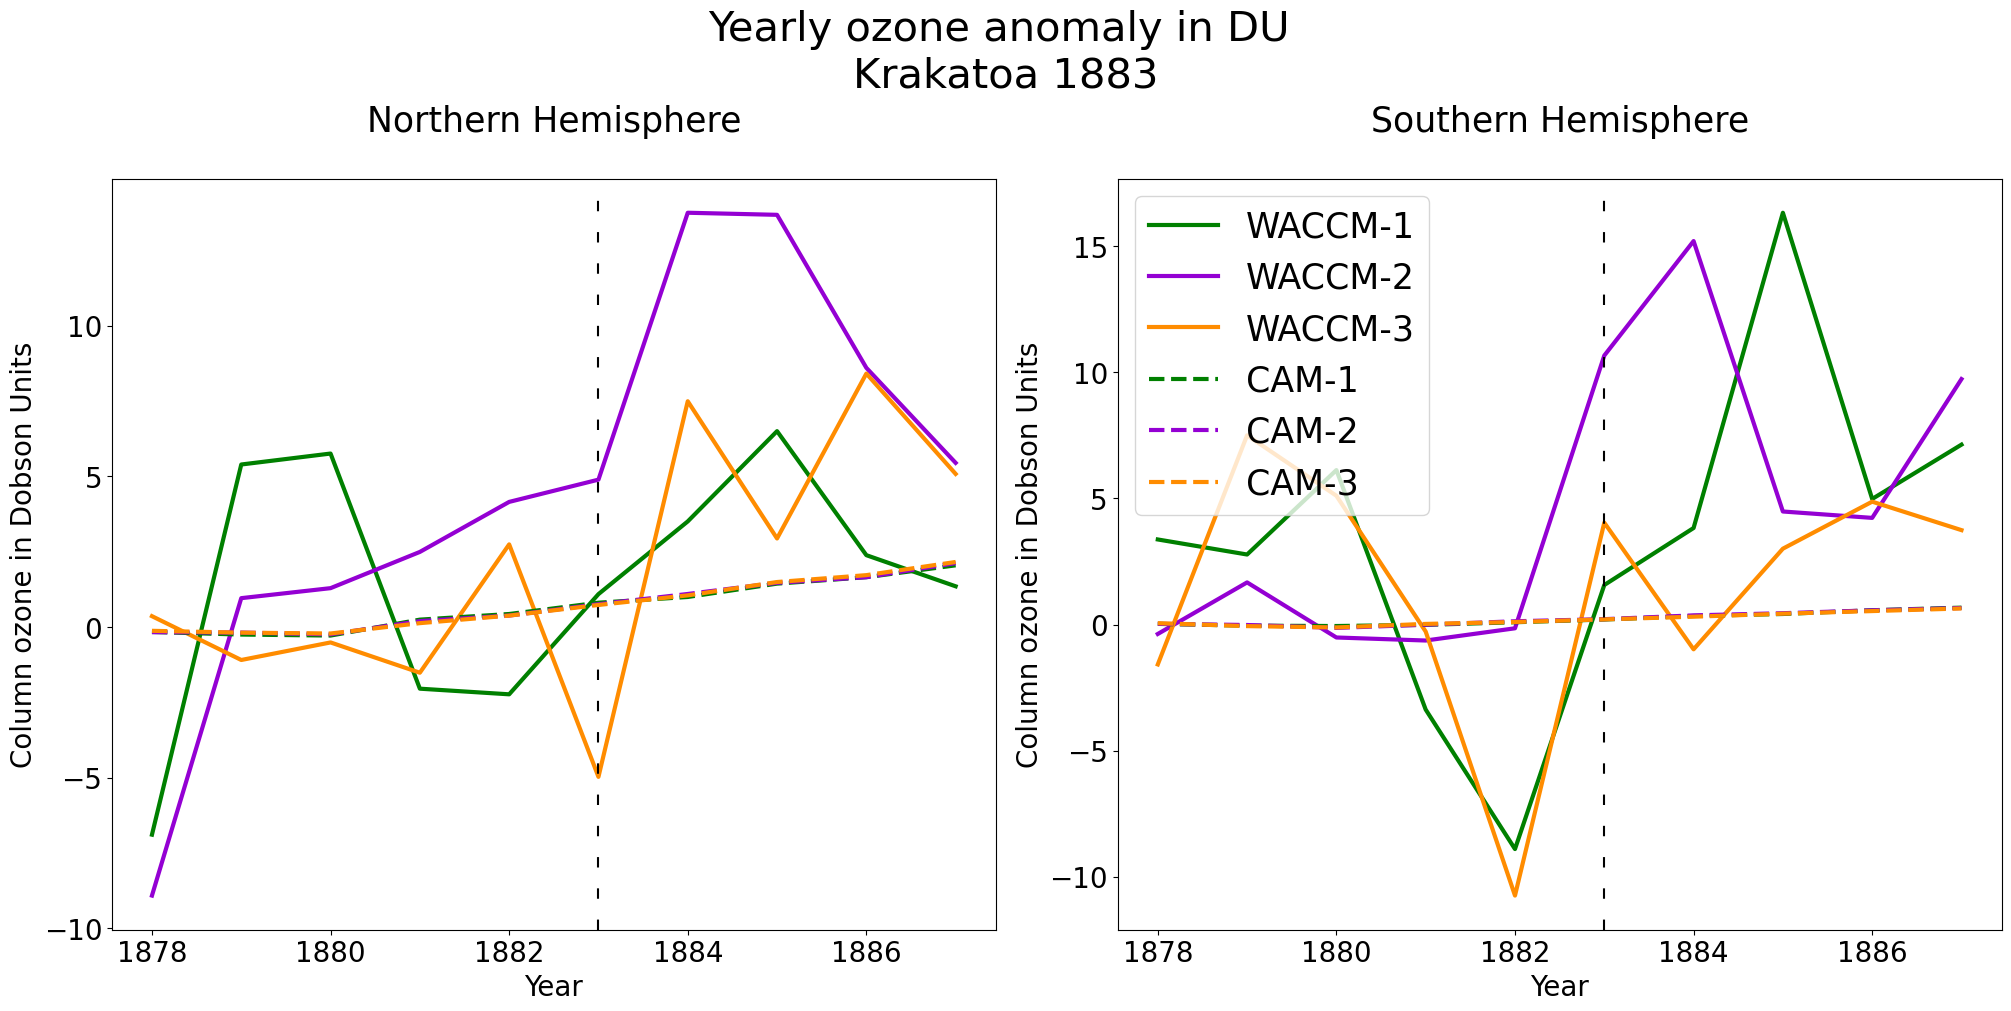

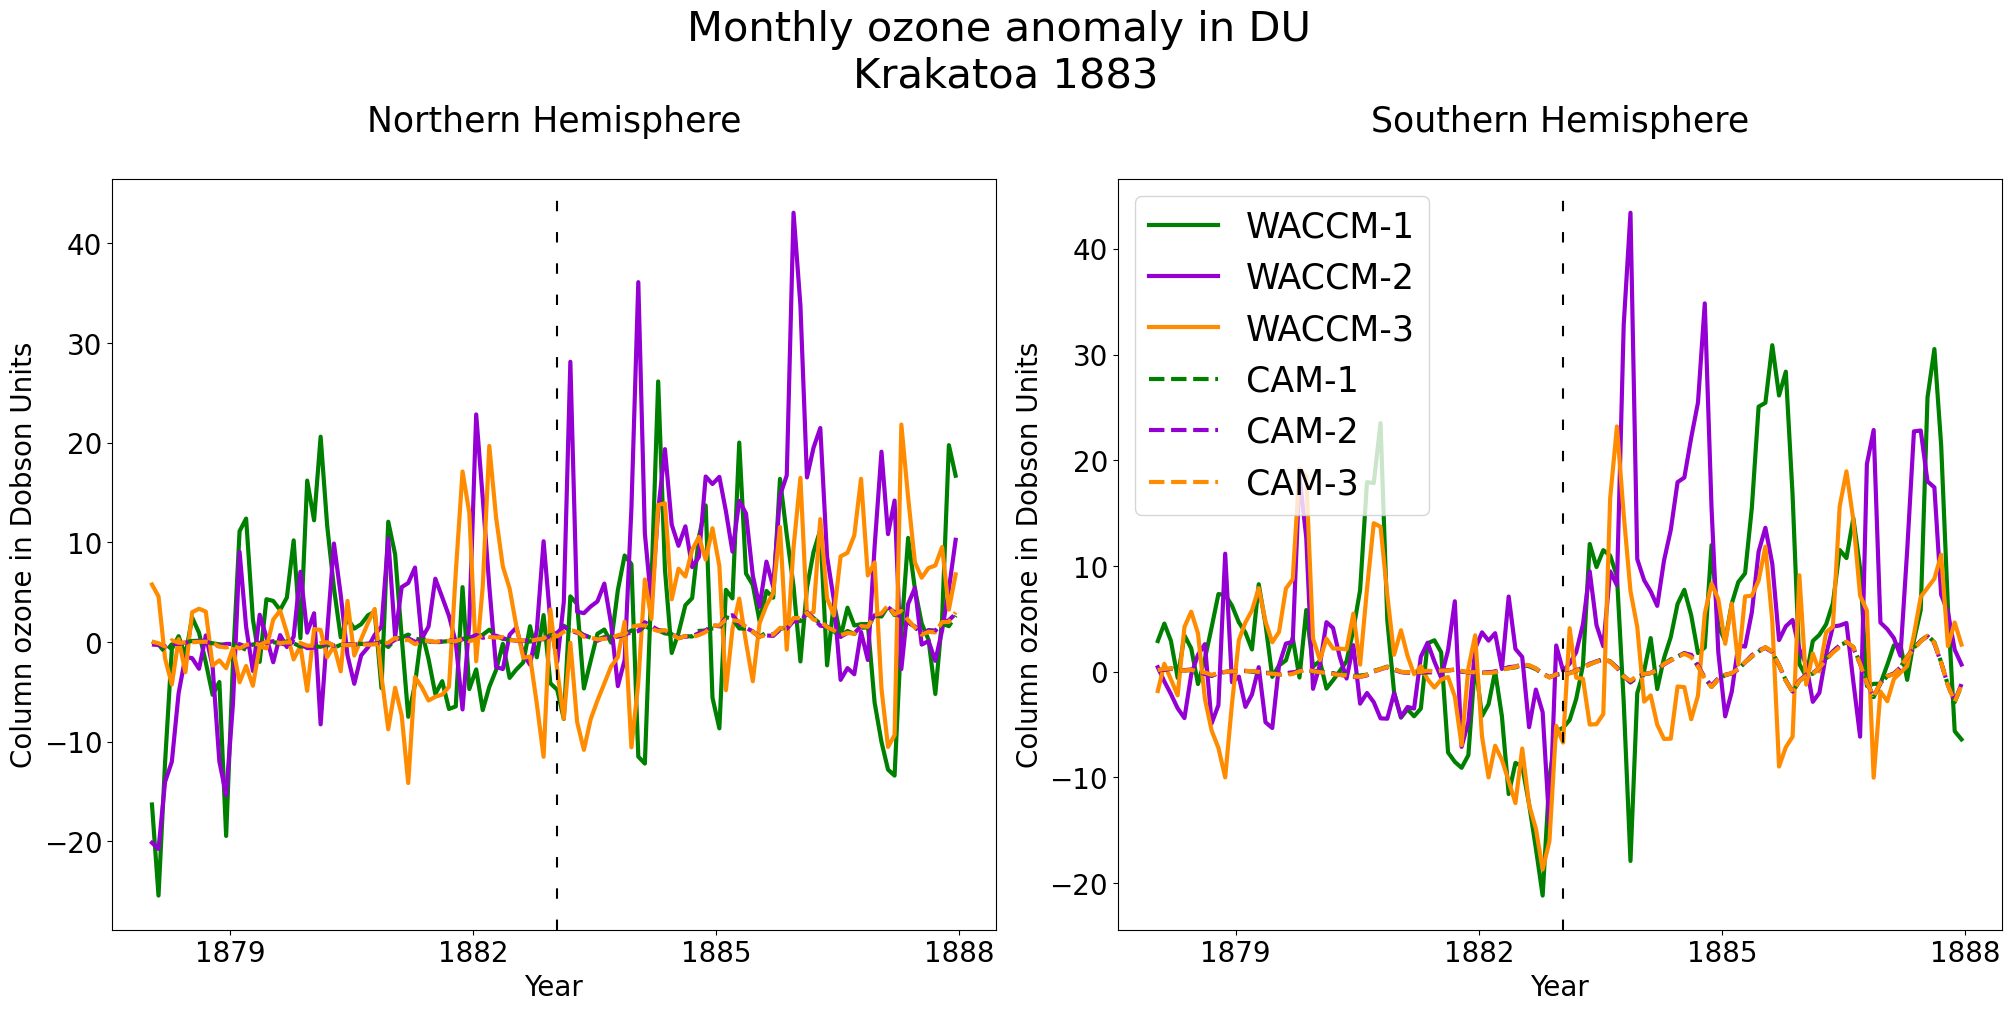

In [14]:
plot_year(year_waccm_NH_anom_krak_o3, year_waccm_SH_anom_krak_o3, year_cam_NH_anom_krak_o3,year_cam_SH_anom_krak_o3,'Yearly ozone anomaly in DU \nKrakatoa 1883')
plot_month(mon_waccm_NH_anom_krak_o3, mon_waccm_SH_anom_krak_o3, mon_cam_NH_anom_krak_o3,mon_cam_SH_anom_krak_o3,'Monthly ozone anomaly in DU \nKrakatoa 1883')

# Mount Pinatubo eruption in 1991

In [18]:
# Select the starting year 5 years prior to the eruption
start_pina = cftime.DatetimeNoLeap(1986,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
waccm_1986_1996 = waccm.sel(time=slice(start_pina, end_pina))
# CAM
cam_1986_1996 = cam.sel(time=slice(start_pina, end_pina))

# Creates a new variable called totO3 for WACCM and CAM 
waccm_1986_1996_o3 = calculate_total_ozone_p(waccm_1986_1996).totO3
cam_1986_1996_o3 = calculate_total_ozone_p(cam_1986_1996).totO3

Minimum column ozone value: 58.61533162268342
Minimum column ozone value: 123.06848968692877


## Calculate the anomaly

In [24]:
# Yearly
year_waccm_anom_1986_1996_o3 = calc_yearly_anomaly(waccm_1986_1996_o3,1991)
year_cam_anom_1986_1996_o3 = calc_yearly_anomaly(cam_1986_1996_o3,1991)

# Monthly
mon_waccm_anom_1986_1996_o3 = calc_monthly_anomaly(waccm_1986_1996_o3,1991)
mon_cam_anom_1986_1996_o3 = calc_monthly_anomaly(cam_1986_1996_o3,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [25]:
# Yearly
# WACCM
year_waccm_NH_anom_pina_o3 = computeWeightedMean(year_waccm_anom_1986_1996_o3.where(year_waccm_anom_1986_1996_o3['lat']>60.)).compute()
year_waccm_SH_anom_pina_o3 = computeWeightedMean(year_waccm_anom_1986_1996_o3.where(year_waccm_anom_1986_1996_o3['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_pina_o3 = computeWeightedMean(year_cam_anom_1986_1996_o3.where(year_cam_anom_1986_1996_o3['lat']>60.)).compute()
year_cam_SH_anom_pina_o3 = computeWeightedMean(year_cam_anom_1986_1996_o3.where(year_cam_anom_1986_1996_o3['lat']<-60.)).compute()

In [26]:
# Monthly
# WACCM
mon_waccm_NH_anom_pina_o3 = computeWeightedMean(mon_waccm_anom_1986_1996_o3.where(mon_waccm_anom_1986_1996_o3['lat']>60.)).compute()
mon_waccm_SH_anom_pina_o3 = computeWeightedMean(mon_waccm_anom_1986_1996_o3.where(mon_waccm_anom_1986_1996_o3['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_pina_o3 = computeWeightedMean(mon_cam_anom_1986_1996_o3.where(mon_cam_anom_1986_1996_o3['lat']>60.)).compute()
mon_cam_SH_anom_pina_o3 = computeWeightedMean(mon_cam_anom_1986_1996_o3.where(mon_cam_anom_1986_1996_o3['lat']<-60.)).compute()

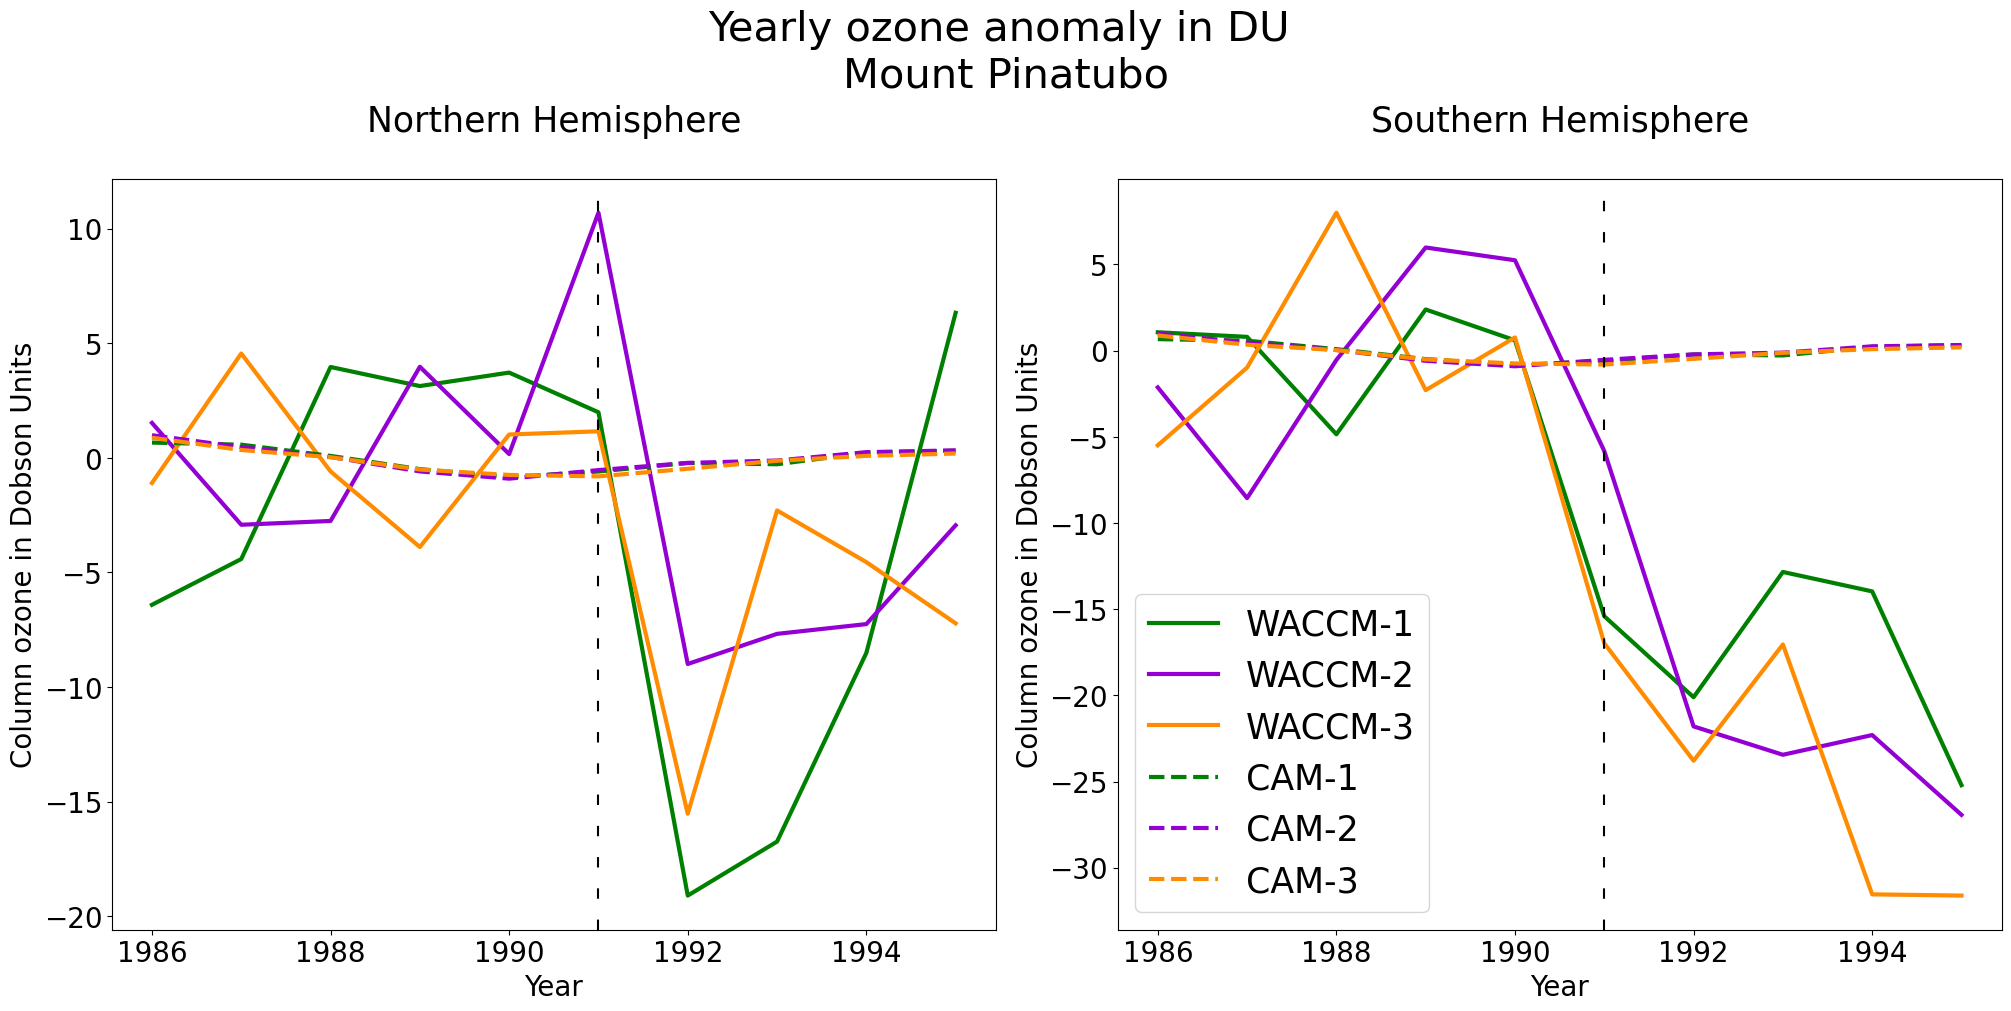

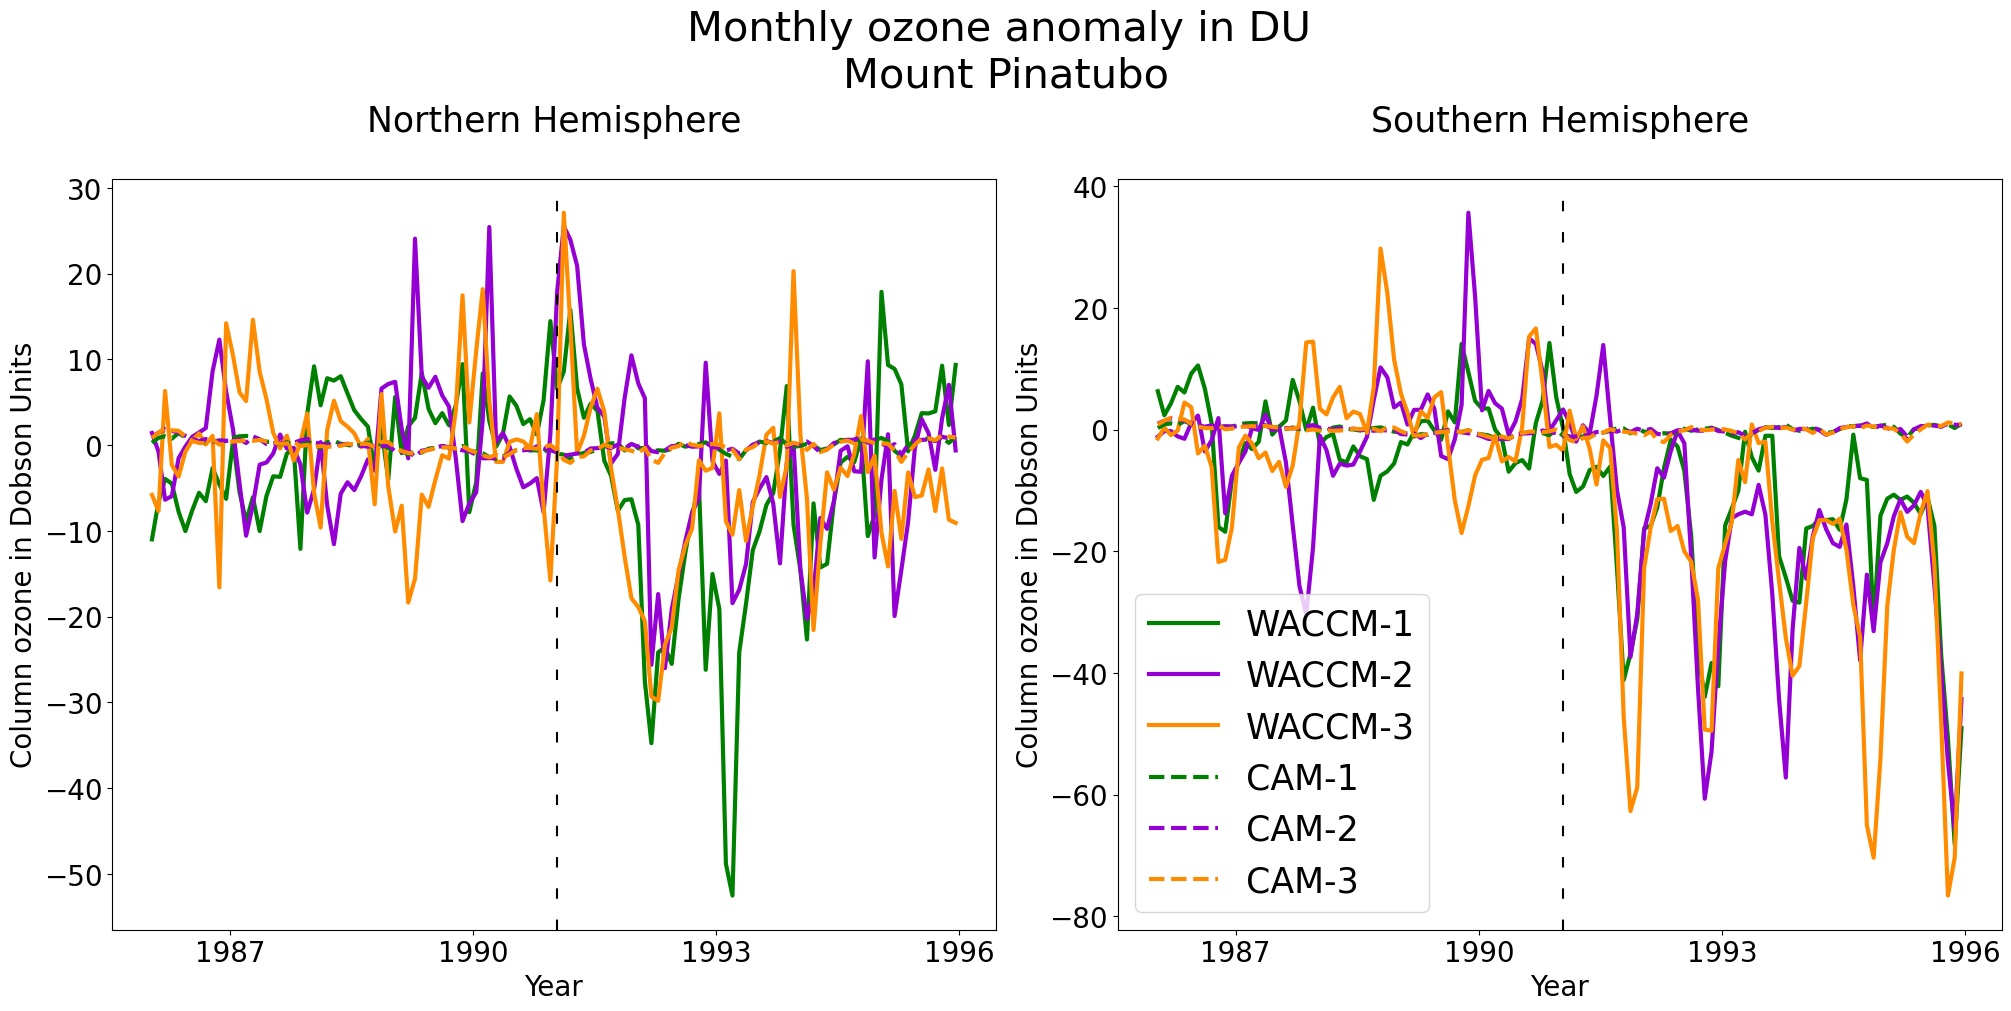

In [29]:
plot_year(year_waccm_NH_anom_pina_o3,year_waccm_SH_anom_pina_o3,year_cam_NH_anom_pina_o3,year_cam_NH_anom_pina_o3,'Yearly ozone anomaly in DU \nMount Pinatubo')
plot_month(mon_waccm_NH_anom_pina_o3,mon_waccm_SH_anom_pina_o3,mon_cam_NH_anom_pina_o3,mon_cam_NH_anom_pina_o3,'Monthly ozone anomaly in DU \nMount Pinatubo')

# Sarychev Peak eruption in 2009

In [14]:
# Select the starting year 5 years prior to the eruption
start_sary = cftime.DatetimeNoLeap(2004,1,15)
end_sary= cftime.DatetimeNoLeap(20014,1,15)

# WACCM
ds_waccm_2004_2014 = ds_waccm.sel(time=slice(start_sary, end_sary))
# CAM
ds_cam_2004_2014 = ds_cam.sel(time=slice(start_sary, end_sary))

# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_2004_2014_o3 = calculate_total_ozone_p(ds_waccm_2004_2014).totO3
ds_cam_2004_2014_o3 = calculate_total_ozone_p(ds_cam_2004_2014).totO3

Minimum column ozone value: 82.25261588765923
Minimum column ozone value: 117.3254629945917


In [15]:
ds_waccm_anom_2004_2014_o3 = calc_yearly_anomaly(ds_waccm_2004_2014_o3,2009)
ds_cam_anom_2004_2014_o3 = calc_yearly_anomaly(ds_cam_2004_2014_o3,2009)

In [16]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_NH_anom_sary_o3 = computeWeightedMean(ds_waccm_anom_2004_2014_o3.where(ds_waccm_anom_2004_2014_o3['lat']>60.)).compute()
waccm_SH_anom_sary_o3 = computeWeightedMean(ds_waccm_anom_2004_2014_o3.where(ds_waccm_anom_2004_2014_o3['lat']<-60.)).compute()

# CAM
cam_NH_anom_sary_o3 = computeWeightedMean(ds_cam_anom_2004_2014_o3.where(ds_cam_anom_2004_2014_o3['lat']>60.)).compute()
cam_SH_anom_sary_o3 = computeWeightedMean(ds_cam_anom_2004_2014_o3.where(ds_cam_anom_2004_2014_o3['lat']<-60.)).compute()

(<Figure size 2000x1000 with 2 Axes>,
 <AxesSubplot:title={'center':' Northern Hemisphere \n'}, xlabel='Year', ylabel='Column ozone in Dobson Units'>,
 <AxesSubplot:title={'center':' Southern Hemisphere \n'}, xlabel='Year', ylabel='Column ozone in Dobson Units'>)

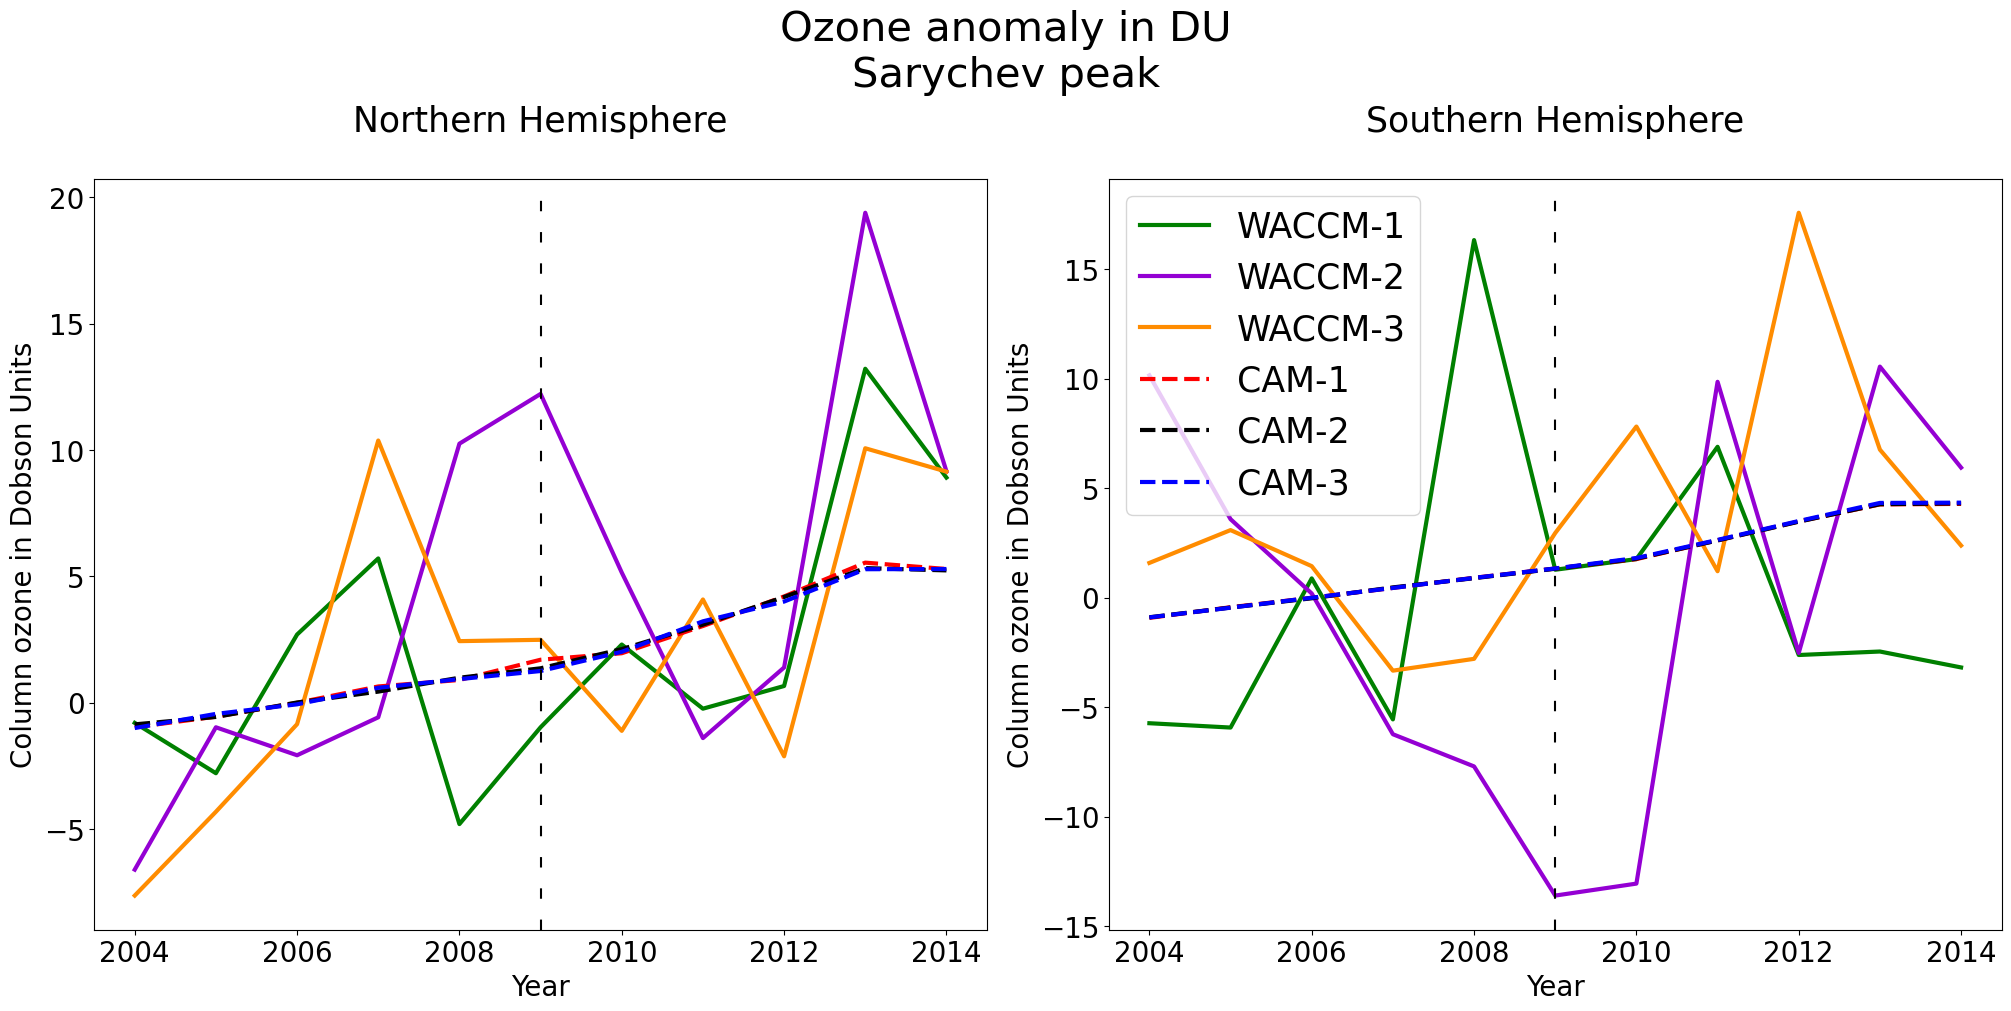

In [18]:
plot_year(waccm_NH_anom_sary_o3,waccm_SH_anom_sary_o3,cam_NH_anom_sary_o3,cam_SH_anom_sary_o3,' Ozone anomaly in DU \nSarychev peak')


In [19]:
cli

<function __main__.plot(waccm1, waccm2, cam1, cam2, eruption_name)>